# Forecasting Furniture Data

### Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. This dataset consists of daily sales data of various products at a superstore 
### We will need to apply Time Series(ARIMA) to build model to predict and forecast the sales of furniture for the next one year i.e. predict future values based on previously observed values. We have a 4-year furniture sales data. 

In [75]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
import pandas as pd
import statsmodels.api as sm
import matplotlib

pd.set_option('display.max_columns', None)

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## Understanding the data

In [76]:
sample_store = pd.read_excel("D:/ANCHIT/Python/SampleSuperstore/Sample - Superstore1.xls")
sample_store.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


### Subsetting only Furniture Data

In [77]:
furniture = sample_store.loc[sample_store['Category'] == 'Furniture']
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [78]:
### Checking the data range
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [79]:
cols = sample_store.columns
cols

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [80]:
#Data preprocessing involves removing columns we dont need, check missing values, aggregate sales by date
cols1 = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode','Customer ID', 'Customer Name', 'Segment', 'Country', 
         'City', 'State','Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols1, axis=1, inplace=True)
furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [81]:
furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture.head()

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
3,2015-10-11,957.5775
5,2014-06-09,48.8600
10,2014-06-09,1706.1840


In [82]:
furniture=furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2016-11-08', '2016-11-08', '2015-10-11', '2014-06-09',
               '2014-06-09', '2017-07-16', '2015-09-25', '2015-09-17',
               '2015-09-17', '2016-12-08',
               ...
               '2015-11-13', '2016-06-03', '2016-12-12', '2017-06-01',
               '2015-12-14', '2015-03-19', '2016-12-05', '2015-09-06',
               '2014-01-21', '2017-02-26'],
              dtype='datetime64[ns]', name='Order Date', length=2121, freq=None)

In [83]:
mod = furniture['Sales'].resample('MS').mean()
mod.head()

Order Date
2014-01-01    312.126250
2014-02-01    262.808286
2014-03-01    441.635030
2014-04-01    305.570654
2014-05-01    288.032792
Freq: MS, Name: Sales, dtype: float64

In [84]:
mod['2017':]

Order Date
2017-01-01    248.501333
2017-02-01    264.089900
2017-03-01    286.669600
2017-04-01    206.044502
2017-05-01    319.953928
2017-06-01    372.717386
2017-07-01    227.173500
2017-08-01    395.945487
2017-09-01    349.737422
2017-10-01    308.226313
2017-11-01    374.310253
2017-12-01    296.296857
Freq: MS, Name: Sales, dtype: float64

## Exploratory Data Analysis

<function matplotlib.pyplot.show(*args, **kw)>

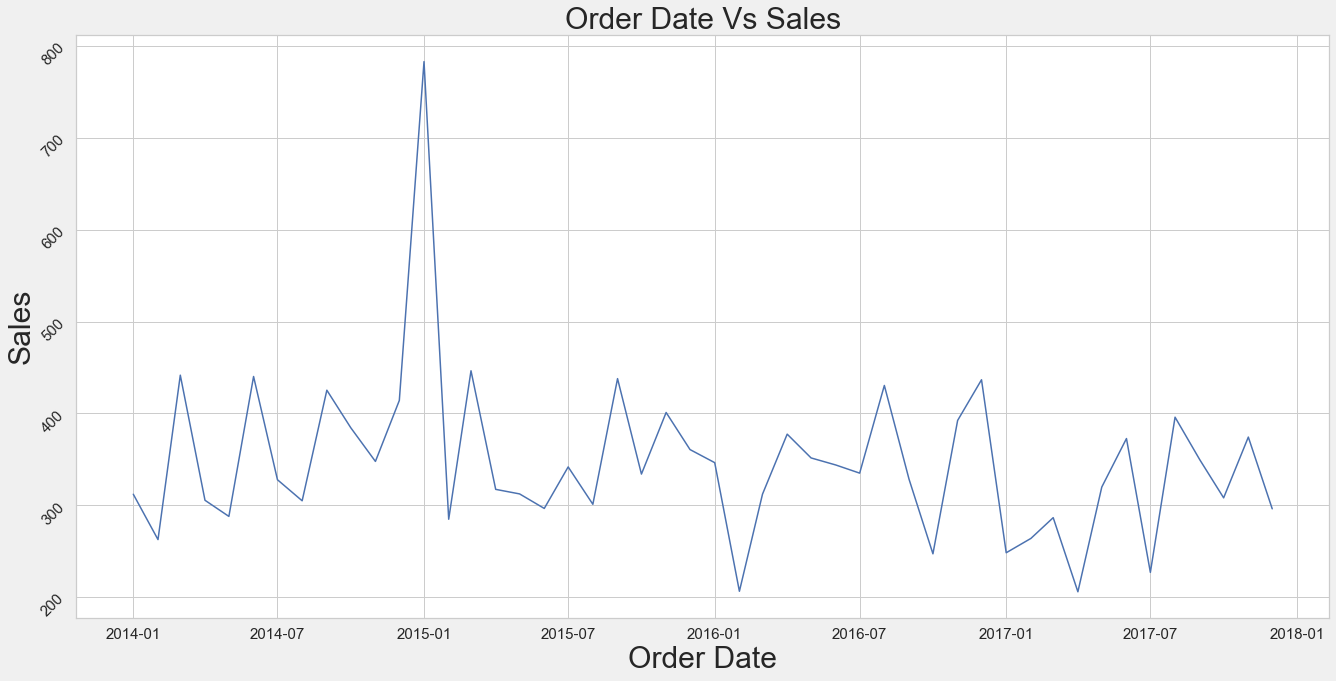

In [85]:
#Visualsing Furniture sales time series data
import seaborn as sns

plt.figure(figsize=(20,10))
sns.set(style = 'whitegrid')
plt.title('Order Date Vs Sales', size=30)
plt.xlabel('Order Date', size=30)
plt.ylabel('Sales', size=30)
plt.yticks(rotation=45, size=15)
plt.xticks(size=15)
plt.plot(mod)
plt.show

## Decompose time series into 3 distinct components : trend, seasonality & noise

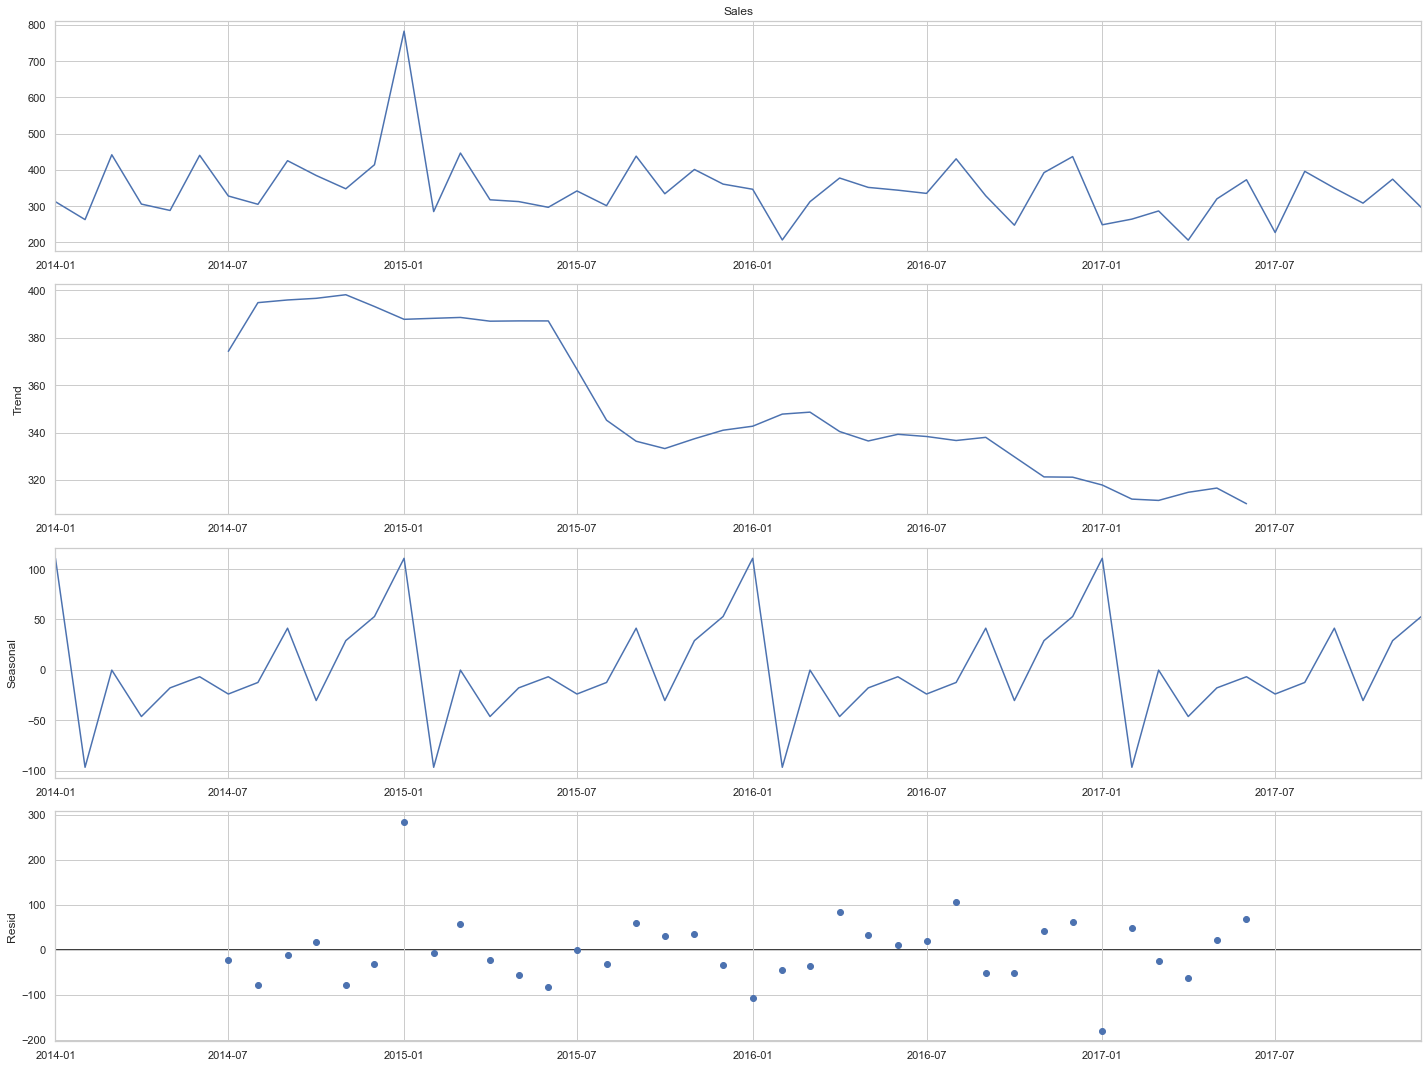

In [86]:
from pylab import rcParams
rcParams['figure.figsize']=20,15
decomposition = sm.tsa.seasonal_decompose(mod, model='additive')
fig = decomposition.plot()
plt.show()

#The plot below clearly shows that the sales of furniture is unstable

In [87]:
#Time Series forecasting with ARIMA
#ARIMA models are denoted with the notation ARIMA(p,d,p). These three parameters account for seasonality, trend & noise in data
p=d=q=range(0,2)
pdq=list(itertools.product(p,d,q))
seasonal_pdq=[(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]
print('Example of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Example of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [88]:
#Using Grind search for parameter tuning
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [89]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod_1=sm.tsa.statespace.SARIMAX(mod, 
                                          order=param, 
                                          seasonal_order=param_seasonal, 
                                          endorce_stationarity=False, 
                                          enforce_invertibility=False)
            results=mod_1.fit()
            print('ARIMA{}x{}12-AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12-AIC:702.6705312928079
ARIMA(0, 0, 0)x(0, 0, 1, 12)12-AIC:2149.0387405416773
ARIMA(0, 0, 0)x(0, 1, 0, 12)12-AIC:453.9753787461527
ARIMA(0, 0, 0)x(0, 1, 1, 12)12-AIC:445.70342832934745
ARIMA(0, 0, 0)x(1, 0, 0, 12)12-AIC:628.5073498144793
ARIMA(0, 0, 0)x(1, 0, 1, 12)12-AIC:1242.9004717045304
ARIMA(0, 0, 0)x(1, 1, 0, 12)12-AIC:449.8565436289623
ARIMA(0, 0, 0)x(1, 1, 1, 12)12-AIC:447.66543172441
ARIMA(0, 0, 1)x(0, 0, 0, 12)12-AIC:668.1480179335549
ARIMA(0, 0, 1)x(0, 0, 1, 12)12-AIC:966.4416352888993
ARIMA(0, 0, 1)x(0, 1, 0, 12)12-AIC:455.46079304285087
ARIMA(0, 0, 1)x(0, 1, 1, 12)12-AIC:447.60523417330097
ARIMA(0, 0, 1)x(1, 0, 0, 12)12-AIC:623.1645142879663
ARIMA(0, 0, 1)x(1, 0, 1, 12)12-AIC:2078.924855914539
ARIMA(0, 0, 1)x(1, 1, 0, 12)12-AIC:451.7948630420445
ARIMA(0, 0, 1)x(1, 1, 1, 12)12-AIC:449.54564414006757
ARIMA(0, 1, 0)x(0, 0, 0, 12)12-AIC:592.3531323018664
ARIMA(0, 1, 0)x(0, 0, 1, 12)12-AIC:1181.1669570151198
ARIMA(0, 1, 0)x(0, 1, 0, 12)12-AIC:454.53

In [90]:
#Fitting the ARIMA Model
mod_1 = sm.tsa.statespace.SARIMAX(mod, 
                              order=(1,1,1), 
                              seasonal_order=(1,1,0,12), 
                              endorce_stationarity=False, 
                              enforce_invertibility=False)
results = mod_1.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0159      0.251     -0.063      0.949      -0.508       0.476
ma.L1         -1.0000      0.233     -4.288      0.000      -1.457      -0.543
ar.S.L12      -0.4843      0.078     -6.213      0.000      -0.637      -0.332
sigma2      1.245e+04   1.87e-05   6.64e+08      0.000    1.24e+04    1.24e+04


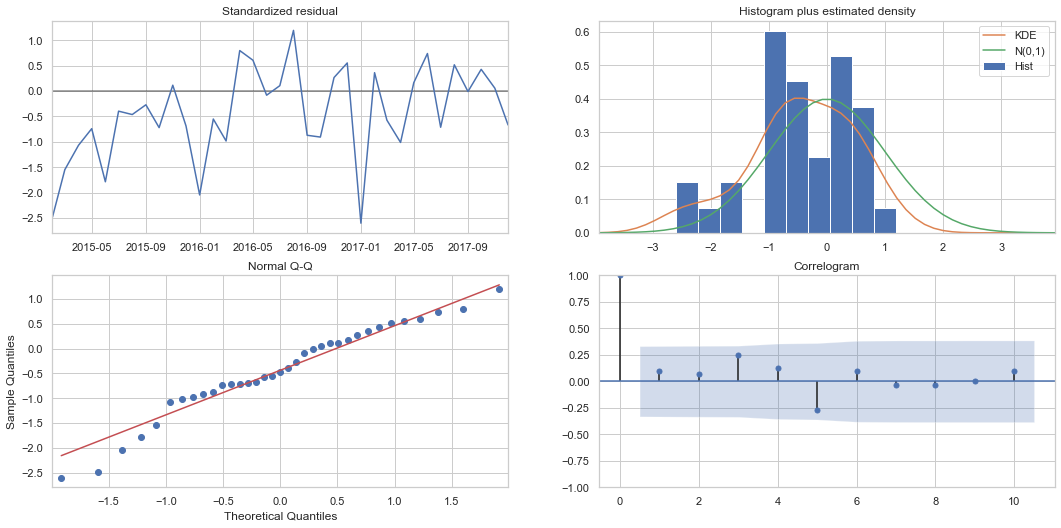

In [91]:
#Running the model diagnostic
results.plot_diagnostics(figsize=(16,8))
plt.show()

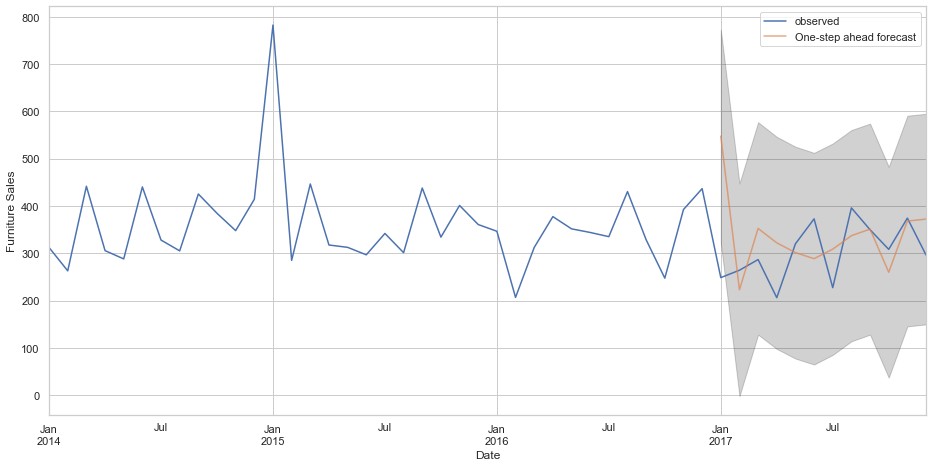

In [92]:
# It is not perfect but our model diagnostics suggests that the model residuals are noramlly distributed
#Validating forecasts
#To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series & we set forecasts to start at 2017-01-01 to the end of the data

pred=results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci=pred.conf_int()
ax = mod['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7, 
figsize=(14,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Root Mean Squared Error of our Forecasts

In [94]:
mod_forecasted=pred.predicted_mean
mod_truth = mod['2017-01-01':]
mse=((mod_forecasted - mod_truth)**2).mean()
print('The Mean squared error of our forecast is {}'.format(round(mse,2)))
print('The Root Mean squared error of our forecast is {}'.format(round(np.sqrt(mse),2)))

The Mean squared error of our forecast is 11222.26
The Root Mean squared error of our forecast is 105.94


### Producing & Visualising forecasts

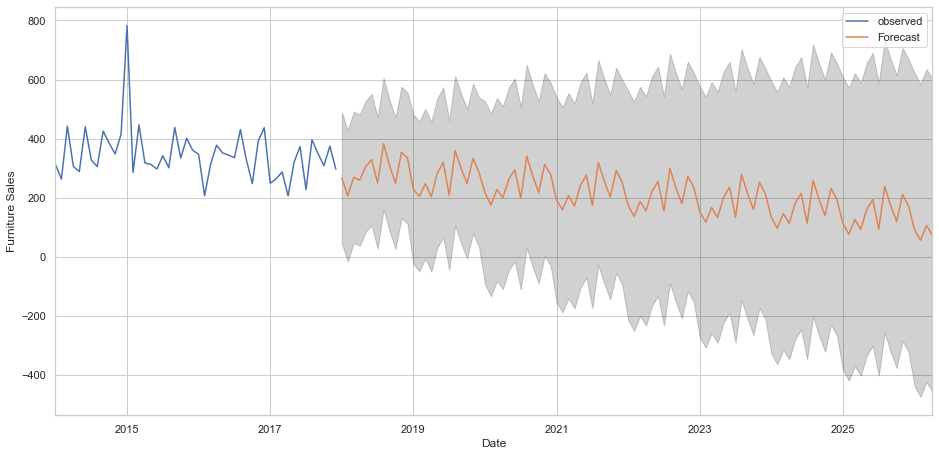

In [95]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = mod.plot(label='observed', figsize=(14,7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Our Model clearly captured furniture sales seasonlity. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out in the future